# DiscRimNN
## Option 1
Create a model that reads a sequence of numbers, one number at a time, and classify that number based on all previously seen numbers.

## Option 2
Create a model that reads a sequence of numbers and classifies the last number in the sequence based on the previous numbers in the sequence.

## How this project is useful
 1. full control over dataset
 2. infinite dataset
 3. can study all three RNN base problems (classification, prediction, forcasting).
 

## Project Steps
 1. create dataset
 2. create network
 3. train network
 4. test network

## TODO
 - [x] create single signal generator class
 - [x] create mixed signal generator class
 - [ ] create signal noise functions (Gaussian, OU, etc.)
 - [ ] create timestep noise functions 
 - [x] add legends to plots.
 - [ ] during training, save outlier X, y train sets to file for further analysis.
 - [x] save configuration of mixed signal properties as json.
 - [ ] make plots of the mixed signal with colors mapped to hidden layers, lstm states, etc.
 - [ ] unit tests for signal.py
 - [ ] create startup.py to handle project directories and other goodies.
 - [ ] fix savefig clipping the bottoms of our figures.

## Data generator parameters to test
 1. All 4 wave variables
  - amplitude
  - frequency (period)
  - offset
  - phase
 2. sequence length
 3. signal noise
 4. timestep noise
 5. number of signals
 

## Model hyperparameters to test
 - number of timestamps `n_timestamps`
 - number of timesteps `n_timesteps`
 - number of neurons per LSTM `n_neurons`
 - number of LSTM recurrent cells
 - number of LSTM layers
 - number of epochs
 - batch_size
 

## Questions to answer
 Q: What would a batch look like?
 
 Q: How many LSTM layers do we need? nodes per LSTM layer?
 
 Q: Can we learn if our timestamps are not uniformly spaced.
 
 Q: Should we make the LSTM layers stateful?
 
 Q: Should we use sliding window or boxcar sequences?
 
 Q: For stateful LSTM's must we `model.reset_states()` after any `model.evaluate()` and/or `model.predict()` calls? 
 
 A: **YES** Ref: Greenlee's book on LSTM's. p.49

In [1]:
import os
import sys
import json
# import h5py
from datetime import datetime
import numpy as np
import pandas as pd
from pandas.plotting import table
from random import random

import matplotlib.pyplot as plt
%matplotlib inline

# from keras import backend as K
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Masking
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model


/home/maddoxw/.virtualenvs/DiscRimNN/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16
BIGGEST_SIZE = 20
plt.rc('font', size=BIGGEST_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=BIGGEST_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=BIGGEST_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGEST_SIZE)  # fontsize of the figure title

In [3]:
def highlight_column_matches(data, column='', color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_mixed = data == data[column]
        return [attr if v else '' for v in is_mixed]
    else:  # from .apply(axis=None)
        is_mixed = data == data[column]
        return pd.DataFrame(np.where(is_mixed, attr, ''), index=data.index, columns=data.columns)

def get_timestamp(t=None, format='%Y-%m-%d_%H-%M-%S'):
    """Return timestamp as a string; default: current time, format: YYYY-DD-MM_hh-mm-ss."""
    if t is None:
        t = datetime.now()
    return t.strftime(format)

def plot_stats(csv_filename, columns=['total_reward'], **kwargs):
    """Plot specified columns from CSV file."""
    df_stats = pd.read_csv(csv_filename)
    df_stats[columns].plot(**kwargs)

# Ref http://connor-johnson.com/2014/02/01/smoothing-with-exponentially-weighted-moving-averages/
def holt_winters_second_order_ewma(x, span, beta):
    N = x.size
    alpha = 2.0 / (1 + span)
    s = np.zeros((N,))
    b = np.zeros((N,))
    s[0] = x[0]
    for i in range(1, N):
        s[i] = alpha * x[i] + (1 - alpha) * (s[i-1] + b[i-1])
        b[i] = beta * (s[i] - s[i-1]) + (1 - beta) * b[i-1]
    return s

def reversed_recombined_holt_winters(x, span=15, beta=0.3):
    # take EWMA in both directions with a smaller span term
    fwd = holt_winters_second_order_ewma(x, span, beta)
    bwd = holt_winters_second_order_ewma(x[::-1], span, beta)
    c = np.vstack((fwd, bwd[::-1])) # lump fwd and bwd together
    c = np.mean(c, axis=0) # average
    return c

## Build a signal generator

The signal generator builds waves using the standard form:

$$x(t) = h + A\sin\left(\frac{2\pi t}{T} + \phi\right)$$

where $h$ is the height (vertical offset), $A$ is the amplitude (vertical scale), $T$ is the period (horizontal scale), and $\phi$ is the phase (horizontal offset). This give us fine grained control over how we construct our waves.

In [4]:
from discrimnn.signal import MixedSignal

In [5]:
# start off with simplest case for proof of concept
sig1_coeffs = {
    'amplitude': {'mean': 1.0, 'delta': 0}, 
    'offset': {'mean': -0.1, 'delta': 0}, 
    'period': {'mean': 1, 'delta': 0},
    'phase': {'mean': 0, 'delta': 0},
    'name': 'A',
    'color': '#ff0000'
}
sig2_coeffs = {
    'amplitude': {'mean': 1.0, 'delta': 0}, 
    'offset': {'mean': 0.0, 'delta': 0}, 
    'period': {'mean': 1, 'delta': 0},
    'phase': {'mean': 0, 'delta': 0},
    'name': 'B',
    'color': '#00ff00'
}
sig3_coeffs = {
    'amplitude': {'mean': 1.0, 'delta': 0}, 
    'offset': {'mean': 0.1, 'delta': 0}, 
    'period': {'mean': 1, 'delta': 0},
    'phase': {'mean': 0, 'delta': 0},
    'name': 'C',
    'color': '#0000ff'
}
sig_coeffs = [sig1_coeffs, sig2_coeffs, sig3_coeffs]

msig_coeffs = {
    'phase': {'mean': 0, 'delta': np.pi}, 
#     'amplitude': {'mean': 10, 'delta': 2}, 
    'period': {'mean': 25, 'delta': 0}, 
#     'offset': {'mean': 1, 'delta': 5}
}

t_initial = 0
t_final = 75
n_timestamps = 301
n_timesteps = 10
time_coeffs = {'start': t_initial, 'stop': t_final, 'n_timestamps': n_timestamps, 'n_timesteps': n_timesteps}

msig = MixedSignal(time_coeffs, sig_coeffs, msig_coeffs, method='sliding') #, run_label='offset_30')
msig.save_config()
X, y = msig.generate()
n_signals = msig.n_signals
print(X.shape, y.shape)

(292, 10, 1) (292, 3)


In [6]:
# df = pd.DataFrame(np.vstack((msig.signals, msig.mixed_signal)).T, index=msig.timestamps, columns=['A', 'B', 'C', 'Mixed'])
df = pd.DataFrame(np.vstack((msig.timestamps, msig.signals, msig.mixed_signal)).T, columns=['time', 'A', 'B', 'C', 'Mixed'])
df[:n_timesteps + 4].style.apply(highlight_column_matches, column='Mixed', color='lightblue', axis=1)

,time,A,B,C,Mixed
0,0,0.147011,0.247011,0.347011,0.347011
1,0.25,0.205068,0.305068,0.405068,0.405068
2,0.5,0.262012,0.362012,0.462012,0.262012
3,0.75,0.317635,0.417635,0.517635,0.417635
4,1,0.371734,0.471734,0.571734,0.571734
5,1.25,0.424111,0.524111,0.624111,0.524111
6,1.5,0.474576,0.574576,0.674576,0.674576
7,1.75,0.522945,0.622945,0.722945,0.622945
8,2,0.56904,0.66904,0.76904,0.56904
9,2.25,0.612695,0.712695,0.812695,0.812695


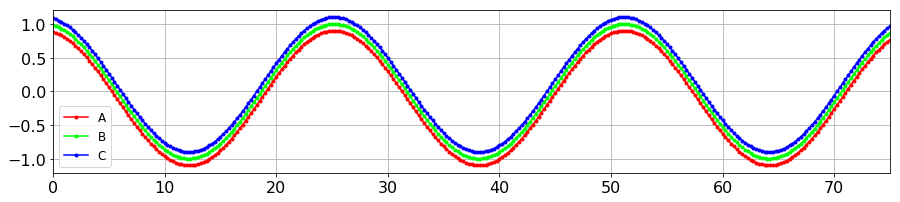

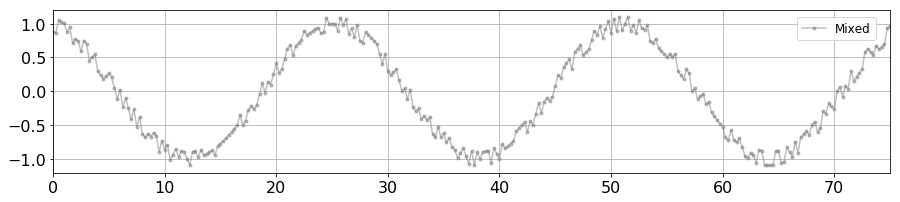

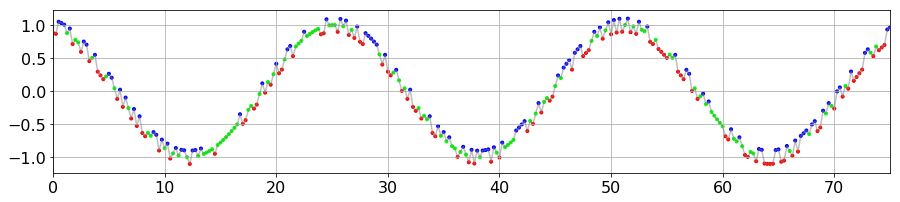

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 3))
legend_labels = []
for i in range(msig.n_signals):
    ax.plot(msig.timestamps, msig.signals[i], marker='.', color=msig.signal_objects[i].color)
    legend_labels.append(msig.signal_objects[i].name)
ax.set_xlim((t_initial, t_final))
plt.grid(True)
ax.legend(legend_labels)
plt.savefig(os.path.join(msig.out_dir, 'signals.png'))
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 3))
ax.plot(msig.timestamps, msig.mixed_signal, color='grey', marker='.', alpha=0.5)
# ax.scatter(msig.timestamps, msig.mixed_signal, color='grey', marker='.')
ax.set_xlim((t_initial, t_final))
plt.grid(True)
ax.legend([msig.name], loc='upper right', bbox_to_anchor=(0.99, 0.99))
plt.savefig(os.path.join(msig.out_dir, 'mixedsignal.png'))
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 3))
ax.plot(msig.timestamps, msig.mixed_signal, color='grey', alpha=0.5)
ax.scatter(msig.timestamps, msig.mixed_signal, marker='.', c=msig.one_hots)
ax.set_xlim((t_initial, t_final))
plt.grid(True)
plt.savefig(os.path.join(msig.out_dir, 'mixedsignal_with_truth.png'))
plt.show()

# Playground

In [21]:
n_neurons = 32
n_layers = 1
batch_size = 4
# define model
model = Sequential()
# model.add(Masking(mask_value=-1, input_shape=(1,)))
model.add(LSTM(n_neurons, input_shape=(n_timesteps, 1), return_sequences=True))
# model.add(LSTM(n_neurons, input_shape=self.input_shape, return_sequences=False, dropout=0.5))
# model.add(LSTM(n_neurons, input_shape=(2, 1)))
# model.add(LSTM(n_neurons, input_shape=(n_timesteps, 2)))
# model.add(LSTM(n_neurons, batch_input_shape=(batch_size, n_timesteps, 1), stateful=True, return_sequences=True))
# model.add(LSTM(n_neurons, batch_input_shape=(n_timesteps, 1, 1), stateful=True, return_sequences=True))
# model.add(LSTM(n_neurons, batch_input_shape=(n_timesteps, 1, 1), stateful=True))
# model.add(LSTM(n_neurons, return_sequences=True))
model.add(LSTM(n_neurons))
# for _ in range(n_layers):
#     model.add(LSTM(n_neurons, stateful=True, return_sequences=True))
# model.add(LSTM(n_neurons, stateful=True))
model.add(Dense(n_signals, activation='softmax'))
# model.add(Dropout(0.5))
# model.add(Reshape((n_neurons, n_signals, 1)))
# model.add(TimeDistributed(Dense(msig.n_signals, activation='softmax')))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

model_config_filename = os.path.join(msig.out_dir, 'model_config.json')
model_summary_filename = os.path.join(msig.out_dir, 'model_plot.png')
with open(model_config_filename, 'w') as ofs:
    json.dump(json.loads(model.to_json()), ofs, indent=4)

plot_model(model, to_file=model_summary_filename, show_shapes=True, show_layer_names=True)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 10, 32)            4352      
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 12,771
Trainable params: 12,771
Non-trainable params: 0
_________________________________________________________________


In [22]:
n_generations = 1000
n_epochs = 1
save_every = 10

model_weights_filename = os.path.join(msig.out_dir, 'model_weights.h5')
training_stats_filename = os.path.join(msig.out_dir, 'training_stats.csv')
stats = {'gen': [], 'loss': [], 'acc': []}
for i in range(n_generations):
#     X, y = msig.generate_batch(64)
    X, y = msig.generate()
    history = model.fit(X, y, 
                        epochs=n_epochs, 
                        batch_size=batch_size, 
                        verbose=1, 
                        shuffle=False)
    stats['gen'].append(i+1)
    stats['loss'].append(history.history['loss'][-1])
    stats['acc'].append(history.history['acc'][-1])
    model.reset_states()
    if i % save_every == 0:
        model.save_weights(model_weights_filename)
        df_stats = pd.DataFrame.from_dict(stats)
        df_stats.to_csv(training_stats_filename, mode='w', index=False, header=True)

model.save_weights(model_weights_filename)
df_stats = pd.DataFrame.from_dict(stats)
df_stats.to_csv(training_stats_filename, mode='w', index=False, header=True)

Epoch 1/1
292/292 [==============================] - 2s 8ms/step - loss: 1.1012 - acc: 0.3664
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 1.0964 - acc: 0.3562
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 1.1019 - acc: 0.3185
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 1.1027 - acc: 0.3390
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 1.1005 - acc: 0.3527
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 1.1022 - acc: 0.3014
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 1.1004 - acc: 0.3253
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 1.1019 - acc: 0.2808
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 1.1006 - acc: 0.3185
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 1.0951 - acc: 0.3664
Epoch 1/1
292/292 [==============================] - 1s 5ms/

292/292 [==============================] - 1s 5ms/step - loss: 0.5490 - acc: 0.7397
Epoch 1/1
292/292 [==============================] - 1s 4ms/step - loss: 0.4394 - acc: 0.8390
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.5969 - acc: 0.7363
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.5457 - acc: 0.7774
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.4901 - acc: 0.8082
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.5916 - acc: 0.7363
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.5214 - acc: 0.7911
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.6011 - acc: 0.7842
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.4830 - acc: 0.7945
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.4466 - acc: 0.8219
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - los

292/292 [==============================] - 1s 5ms/step - loss: 0.3420 - acc: 0.8938
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.4136 - acc: 0.8356
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.3826 - acc: 0.8938
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.2902 - acc: 0.8973
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.3374 - acc: 0.8904
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.4148 - acc: 0.8356
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.3911 - acc: 0.8527
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.3963 - acc: 0.8459
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.5314 - acc: 0.8390
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.3821 - acc: 0.8527
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - los

292/292 [==============================] - 1s 5ms/step - loss: 0.4238 - acc: 0.8767
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.4076 - acc: 0.8664
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.3024 - acc: 0.8767
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.2673 - acc: 0.9144
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.3839 - acc: 0.8664
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.4525 - acc: 0.8390
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.2230 - acc: 0.9281
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.3309 - acc: 0.8527
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.3107 - acc: 0.9041
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.2977 - acc: 0.8836
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - los

292/292 [==============================] - 1s 4ms/step - loss: 0.3606 - acc: 0.8801
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.1995 - acc: 0.9247
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.3297 - acc: 0.8973
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.2080 - acc: 0.9247
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.4081 - acc: 0.8459
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.1945 - acc: 0.9247
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.5793 - acc: 0.8459
Epoch 1/1
292/292 [==============================] - 1s 4ms/step - loss: 0.4830 - acc: 0.8493
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.4059 - acc: 0.8596
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.2470 - acc: 0.8973
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - los

292/292 [==============================] - 1s 5ms/step - loss: 0.2231 - acc: 0.9247
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.3236 - acc: 0.8699
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.2365 - acc: 0.9041
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.2601 - acc: 0.9281
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.2036 - acc: 0.9349
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.2300 - acc: 0.9110
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.2922 - acc: 0.8870
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.1785 - acc: 0.9452
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.4594 - acc: 0.8801
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.1910 - acc: 0.9281
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - los

292/292 [==============================] - 1s 5ms/step - loss: 0.1578 - acc: 0.9521
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.1406 - acc: 0.9384
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.2219 - acc: 0.9212
Epoch 1/1
292/292 [==============================] - 1s 4ms/step - loss: 0.1759 - acc: 0.9452
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.2042 - acc: 0.9247
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.2320 - acc: 0.9178
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.1698 - acc: 0.9212
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.1786 - acc: 0.9349
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.3473 - acc: 0.9007
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.3609 - acc: 0.8870
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - los

292/292 [==============================] - 1s 5ms/step - loss: 0.2177 - acc: 0.9315
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.1288 - acc: 0.9623
Epoch 1/1
292/292 [==============================] - 1s 4ms/step - loss: 0.2170 - acc: 0.9349
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.2268 - acc: 0.9007
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.4834 - acc: 0.8493
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.2570 - acc: 0.8904
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.1957 - acc: 0.9384
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.2204 - acc: 0.9212
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.1078 - acc: 0.9692
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.1414 - acc: 0.9658
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - los

292/292 [==============================] - 1s 5ms/step - loss: 0.3563 - acc: 0.8801
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.2313 - acc: 0.9212
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.2420 - acc: 0.9178
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.1235 - acc: 0.9555
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.2960 - acc: 0.9041
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.2145 - acc: 0.9110
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.2681 - acc: 0.9349
Epoch 1/1
292/292 [==============================] - 1s 4ms/step - loss: 0.1927 - acc: 0.9281
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.1535 - acc: 0.9418
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.2778 - acc: 0.9075
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - los

292/292 [==============================] - 1s 5ms/step - loss: 0.1783 - acc: 0.9486
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.3937 - acc: 0.8630
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.2506 - acc: 0.9075
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.2187 - acc: 0.9349
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.2067 - acc: 0.9384
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.2306 - acc: 0.9281
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.2004 - acc: 0.9247
Epoch 1/1
292/292 [==============================] - 1s 4ms/step - loss: 0.0795 - acc: 0.9760
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.2403 - acc: 0.8973
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.1650 - acc: 0.9384
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - los

292/292 [==============================] - 1s 5ms/step - loss: 0.2364 - acc: 0.9212
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.0530 - acc: 0.9897
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.4452 - acc: 0.8733
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.0976 - acc: 0.9760
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.3010 - acc: 0.9247
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.3272 - acc: 0.9075
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.2861 - acc: 0.8938
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.2218 - acc: 0.9281
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.1458 - acc: 0.9418
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.1869 - acc: 0.9247
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - los

292/292 [==============================] - 1s 5ms/step - loss: 0.0531 - acc: 0.9897
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.2045 - acc: 0.9144
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.1810 - acc: 0.9281
Epoch 1/1
292/292 [==============================] - 1s 4ms/step - loss: 0.2498 - acc: 0.9212
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.2331 - acc: 0.9418
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.3351 - acc: 0.9007
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.2363 - acc: 0.9178
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.3213 - acc: 0.9041
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - loss: 0.1352 - acc: 0.9418
Epoch 1/1
292/292 [==============================] - 1s 4ms/step - loss: 0.0956 - acc: 0.9623
Epoch 1/1
292/292 [==============================] - 1s 5ms/step - los

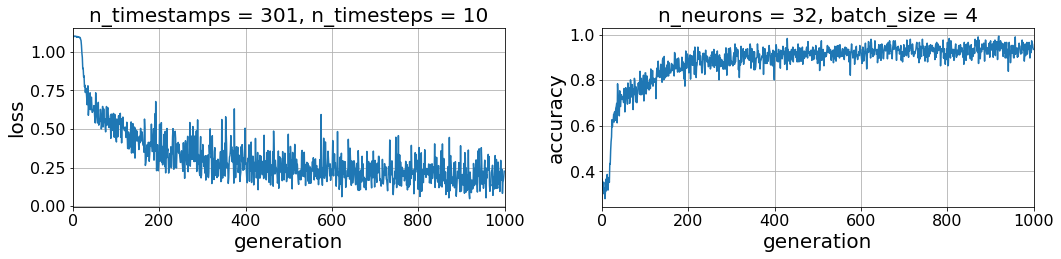

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

ax[0].plot(df_stats.loss)
# ax[0].plot(df_stats.loss, color='grey', alpha=0.3)
# hw_loss = reversed_recombined_holt_winters(np.array(df_stats.loss))
# ax[0].plot(hw_loss)
ax[0].set_title(r'n_timestamps = {}, n_timesteps = {}'.format(n_timestamps, n_timesteps))
ax[0].set_xlabel(r'generation')
ax[0].set_xlim((0, n_generations))
ax[0].set_ylabel(r'loss')
ax[0].grid(True)

ax[1].plot(df_stats.acc)
# ax[1].plot(df_stats.acc, color='grey', alpha=0.3)
# hw_acc = reversed_recombined_holt_winters(np.array(df_stats.acc))
# ax[1].plot(hw_acc)
ax[1].set_title(r'n_neurons = {}, batch_size = {}'.format(n_neurons, batch_size))
ax[1].set_xlabel(r'generation')
ax[1].set_xlim((0, n_generations))
ax[1].set_ylabel(r'accuracy')
ax[1].grid(True)
plt.savefig(os.path.join(msig.out_dir, 'loss_acc.png'))
plt.tight_layout()
plt.show()

292/292 [==============================] - 0s 1ms/step


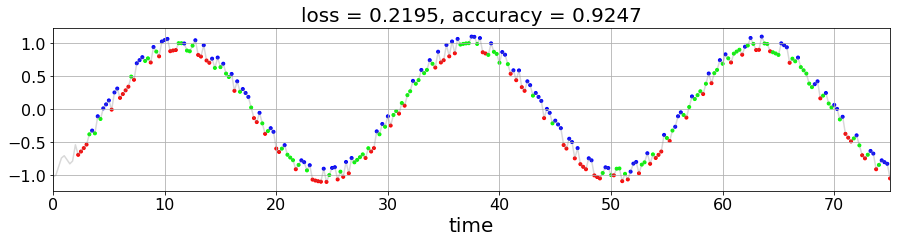

In [47]:
x_test, y_test = msig.generate()
score = model.evaluate(x_test, y_test, batch_size=batch_size)
model.reset_states()
# y_hat = model.predict(x_test, batch_size=batch_size)
# y_pred = np.argmax(y_hat, axis=1)
y_pred = model.predict_classes(x_test, batch_size=batch_size)
model.reset_states()
# y_pred_colors = [msig.signal_objects[i].color for i in msig.classes[msig.n_timesteps-1:]]
y_pred_colors = [msig.signal_objects[i].color for i in y_pred]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 3))
ax.plot(msig.timestamps, msig.mixed_signal, color='grey', alpha=0.3)
ax.scatter(msig.timestamps[msig.n_timesteps-1:], x_test[:, -1, 0], marker='.', c=y_pred_colors)
ax.set_title('loss = {:<6.4f}, accuracy = {:<6.4f}'.format(*score))
ax.set_xlabel('time')
ax.set_xlim(t_initial, t_final)
plt.grid(True)
plt.savefig(os.path.join(msig.out_dir, 'eval_pred.png'))
plt.show()

(292, 10, 1)
(292, 3)
292/292 [==============================] - 0s 1ms/step
[0.0334433590439515, 0.9863013698630136]
(292, 3)
(292,)


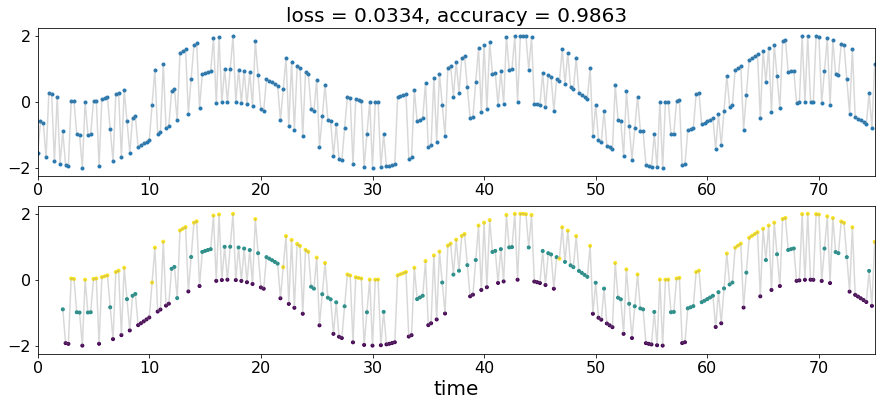

In [28]:
x_test, y_test = msig.generate()
print(x_test.shape)
print(y_test.shape)

score = model.evaluate(x_test, y_test, batch_size=batch_size)
model.reset_states()
print(score)

y_pred = model.predict_classes(x_test, batch_size=batch_size)
# y_hat = model.predict(x_test, batch_size=batch_size)
# y_pred = np.argmax(y_hat, axis=1)
# y_error = 1.0 - np.max(y_hat, axis=1)
model.reset_states()
print(y_hat.shape)
print(y_pred.shape)
# print(y_error.shape)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 6))

ax[0].plot(msig.timestamps, msig.mixed_signal, color='grey', alpha=0.3)
ax[0].scatter(msig.timestamps, msig.mixed_signal, marker='.')
ax[0].set_title('loss = {:<6.4f}, accuracy = {:<6.4f}'.format(*score))
ax[0].set_xlim(t_initial, t_final)

ax[1].plot(msig.timestamps[msig.n_timesteps-1:], x_test[:, -1, 0], color='grey', alpha=0.3)
ax[1].scatter(msig.timestamps[msig.n_timesteps-1:], x_test[:, -1, 0], marker='.', c=y_pred)
ax[1].set_xlim(t_initial, t_final)
ax[1].set_xlabel('time')
plt.show()

In [ ]:
n_batch = 1
print(X.shape)
print(n_batch)
# re-define model
new_model = Sequential()
new_model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True, return_sequences=True))
new_model.add(LSTM(n_neurons))
new_model.add(Dense(msig.n_signals, activation='softmax'))
# copy weights
old_weights = model.get_weights()
new_model.set_weights(old_weights)
new_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

x_test, y_test = msig.generate()
score = new_model.evaluate(x_test, y_test, batch_size=n_batch)
print(score)

plt.figure(figsize=(15, 3))
plt.plot(msig.timestamps, msig.mixed_signal, color='grey', alpha=0.3)
plt.scatter(msig.timestamps, msig.mixed_signal, marker='.', c=msig.one_hots)
plt.show()

In [ ]:
y_hat = new_model.predict(x_test, batch_size=msig.n_samples)
for i in range(len(x_test)):
    print('Expected', y_test[i], 'Predicted', y_hat[i])

In [ ]:
x_test, y_test = msig()
print(x_test.shape)
print(y_test.shape)
y_hat = new_model.predict(x_test, batch_size=msig.n_samples)
print(y_hat.shape)
y_pred = np.argmax(y_hat, axis=1)
print(y_pred.shape)
y_error = np.max(y_hat, axis=1)
print(y_error.shape)

plt.figure(figsize=(15, 3))
plt.plot(msig.timestamps[msig.n_timesteps-1:], x_test[:, -1, 0], color='grey', alpha=0.3)
plt.scatter(msig.timestamps[msig.n_timesteps-1:], x_test[:, -1, 0], marker='.', c=y_pred)
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(msig.timestamps[msig.n_timesteps-1:], x_test[:, -1, 0], color='grey', alpha=0.3)
plt.scatter(msig.timestamps[msig.n_timesteps-1:], x_test[:, -1, 0], marker='.', c=y_error)
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(msig.timestamps[-msig.n_samples:], y_error, color='grey', alpha=0.3)
plt.scatter(msig.timestamps[-msig.n_samples:], y_error, marker='.', c=y_error)
plt.show()